#### Imports

In [1]:
#standard imports
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import unicodedata
#import regular expression operations
import re
#import natural language toolkit
import nltk
#import stopwords list
from nltk.corpus import stopwords
# import wordcloud
from wordcloud import WordCloud

import requests
from requests import get
from bs4 import BeautifulSoup
import pandas as pd

import os
from pprint import pprint 
import time
import json

import acquire as a
import wrangle as w
import auto_model2a1 as atm

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression

## Acquire

In [5]:
# url = 'https://github.com/search?o=desc&q=sports+betting&s=stars&type=Repositories&p=1'

# response = get(url)
# response

In [6]:
# soup = BeautifulSoup(response.content, 'html.parser')
# soup

In [7]:
# repos = soup.find_all('a', class_="v-align-middle")
# repos

In [8]:
# extract the links into a list
# link_list = [link['href'] for link in repos]
# link_list

In [9]:
# ['https://github.com'+link['href'] for link in repos]

In [10]:
# url = 'https://github.com/search?o=desc&q=sports+betting&s=stars&type=Repositories&p='

In [11]:
# link_list = []

# for x in range(1,13):
#     # print(x)
#     print(url+str(x))
#     response = get(url+str(x))
#     soup = BeautifulSoup(response.content, 'html.parser')
#     repos = soup.find_all('a', class_="v-align-middle")
#     # print(repos)
#     time.sleep(10)
#     print(len(repos))
#     link_list.extend([link['href'] for link in repos])

In [12]:
# len(link_list)

In [2]:
data = pd.read_json('data.json')

In [5]:
# data = acquire.scrape_github_data()

In [7]:
# json.dump(data, open("data.json", "w"), indent=1)

In [3]:
df = pd.DataFrame(data)

## Prepare!

In [6]:
df = df.dropna()

In [7]:

df.readme_contents = df.readme_contents.str.replace('[/,_,-,:,"]', ' ', regex=True)

df.readme_contents = df.readme_contents.str.replace('heavy', '').str.replace('check', '').str.replace('mark', '')

In [11]:
df.language.value_counts()

Python               24
JavaScript           24
Jupyter Notebook     10
R                     8
HTML                  7
TypeScript            6
Ruby                  5
PHP                   4
C#                    4
Solidity              2
Rust                  2
Visual Basic .NET     1
Go                    1
Swift                 1
Java                  1
Name: language, dtype: int64

In [12]:
def basic_clean(original):
    '''
    Input: original text or .apply(basic_clean) to entire data frame
    Actions: 
    lowercase everything,
    normalizes everything,
    removes anything that's not a letter, number, whitespace, or single quote
    Output: Cleaned text
    '''
    # lowercase everything
    basic_cleaned = original.lower()
    # normalize unicode characters
    basic_cleaned = unicodedata.normalize('NFKD', basic_cleaned)\
    .encode('ascii', 'ignore')\
    .decode('utf-8')
    # Replace anything that is not a letter, number, whitespace or a single quote.
    basic_cleaned = re.sub(r'[^a-z0-9\'\s]', '', basic_cleaned)
    
    return basic_cleaned

In [13]:
def tokenize(basic_cleaned):
    '''
    Input: basic_cleaned text string or .apply(tokenize) to entire data frame
    Actions:
    creates the tokenizer
    uses the tokenizer
    Output: clean_tokenize text string
    '''
    #create the tokenizer
    tokenize = nltk.tokenize.ToktokTokenizer()
    #use the tokenizer
    clean_tokenize = tokenize.tokenize(basic_cleaned, return_str=True)
    
    return clean_tokenize


In [14]:
def remove_stopwords(lemma_or_stem, extra_words=[], exclude_words=[]):
    '''
    Input:text string or .apply(remove_stopwords) to entire data frame
    Action: removes standard stop words
    Output: parsed_article
    '''
    # save stopwords
    stopwords_ls = stopwords.words('english')
    # removing any stopwords in exclude list
    stopwords_ls = set(stopwords_ls) - set(exclude_words)
    # adding any stopwords in extra list
    stopwords_ls = stopwords_ls.union(set(extra_words))
    
    # split words in article
    words = lemma_or_stem.split()
    # remove stopwords from list of words
    filtered = [word for word in words if word not in stopwords_ls]
    # join words back together
    parsed_article = ' '.join(filtered)
    
    return parsed_article


In [15]:
def lemmatize(clean_tokenize):
    '''
    Inputs: clean_tokenize
    Actions: creates lemmatizer and applies to each word
    Outputs: clean_tokenize_lemma
    '''
    #create the lemmatizer
    wnl = nltk.stem.WordNetLemmatizer()
    #use lemmatize - apply to each word in our string
    lemmas = [wnl.lemmatize(word) for word in clean_tokenize.split()]
    #join words back together
    clean_tokenize_lemma = ' '.join(lemmas)
    
    return clean_tokenize_lemma



In [16]:
def clean(text):
    '''
    A simple function to cleanup text data.
    
    Args:
        text (str): The text to be cleaned.
        
    Returns:
        list: A list of lemmatized words after cleaning.
    '''
    
    # basic_clean() function from last lesson:
    # Normalize text by removing diacritics, encoding to ASCII, decoding to UTF-8, and converting to lowercase
    text = (unicodedata.normalize('NFKD', text)
             .encode('ascii', 'ignore')
             .decode('utf-8', 'ignore')
             .lower())
    
    # Remove punctuation, split text into words
    words = re.sub(r'[^\w\s]', '', text).split()
    
    
    # lemmatize() function from last lesson:
    # Initialize WordNet lemmatizer
    wnl = nltk.stem.WordNetLemmatizer()
    
    # Combine standard English stopwords with additional stopwords
    stopwords = nltk.corpus.stopwords.words('english')
    
    # Lemmatize words and remove stopwords
    cleaned_words = [wnl.lemmatize(word) for word in words if word not in stopwords]
    
    return cleaned_words

In [17]:
# df = df.rename(columns={'readme_contents': 'original'})

In [18]:

df['clean_norm_token'] = df.readme_contents.apply(tokenize).apply(basic_clean).apply(remove_stopwords).apply(lemmatize)


df.clean_norm_token = df.clean_norm_token.str.replace('124', '')

In [19]:
#in language column replace language with other if it is not in the top 3 languages
top_5 = df.language.value_counts().head(5).index.tolist()
print(top_5)
df.language = df.language.apply(lambda x: x if x in top_5 else 'other')

['Python', 'JavaScript', 'Jupyter Notebook', 'R', 'HTML']


In [20]:
df.language.value_counts()

other               27
Python              24
JavaScript          24
Jupyter Notebook    10
R                    8
HTML                 7
Name: language, dtype: int64

In [21]:
#baseline is 43%
df.language.value_counts(normalize=True)

other               0.27
Python              0.24
JavaScript          0.24
Jupyter Notebook    0.10
R                   0.08
HTML                0.07
Name: language, dtype: float64

## Explore Phase!

In [6]:
#calls the split function from wrangle.py
train, validate, test = w.split_function_cat_target(df, "language")

In [24]:
df.head()

,repo,language,readme_contents,clean_norm_token
0,/kyleskom/NBA-Machine-Learning-Sports-Betting,Python,# NBA Sports Betting Using Machine Learning 🏀\...,nba sport betting using machine learning img s...
1,/pretrehr/Sports-betting,Python,[![forthebadge made-with-python](http ForThe...,forthebadge madewithpython http forthebadgecom...
2,/llSourcell/ChatGPT_Sports_Betting_Bot,Jupyter Notebook,# ChatGPT Sports Betting Bot\n\nThis is the co...,chatgpt sport betting bot code chatgpt sport b...
3,/georgedouzas/sports-betting,Python,[scikit-learn] <http scikit-learn.org stabl...,scikitlearn http scikitlearnorg stable black b...
4,/sedemmler/WagerBrain,Python,# WagerBrain\nA package containing the essenti...,wagerbrain package containing essential math t...


In [25]:
train.head()

,repo,language,readme_contents,clean_norm_token
96,/lmiller1990/gamblor-web,HTML,## Gamblor\n\nAn web application to assist use...,gamblor web application assist user finding hi...
18,/rockscripts/Sport-Betting-APP-Betfair-Market,HTML,<h1>Sport Betting APP Betfair Market< h1>\n<p>...,h1sport betting app betfair market h1 pi autho...
78,/dolbyio-samples/stream-app-web-viewer,JavaScript,![Livestream viewer image](img livestream-demo...,livestream viewer image img livestreamdemopng ...
28,/mautomic/NitrogenSports-Analysis,Python,## NitrogenSports-Analysis\n\nThis script is m...,nitrogensportsanalysis script meant filtering ...
16,/dashee87/betScrapeR,R,---\r\ntitle README \r\noutput \r\n md docu...,title readme output md document variant github...


In [7]:
python_words = w.clean(' '.join(train[train.language=='Python']['clean_norm_token']))
java_script_words = w.clean(' '.join(train[train.language=='JavaScript']['clean_norm_token']))
jupyter_notebook_words = w.clean(' '.join(train[train.language=='Jupyter Notebook']['clean_norm_token']))
html_words = w.clean(' '.join(train[train.language=='HTML']['clean_norm_token']))
r_words = w.clean(' '.join(train[train.language=='R']['clean_norm_token']))
other_words = w.clean(' '.join(train[train.language=='other']['clean_norm_token']))

all_words = w.clean(' '.join(df['clean_norm_token']))

In [8]:
python_freq = pd.Series(python_words).value_counts()
java_script_freq = pd.Series(java_script_words).value_counts()
jupyter_notebook_freq = pd.Series(jupyter_notebook_words).value_counts()
html_freq = pd.Series(html_words).value_counts()
r_freq = pd.Series(r_words).value_counts()
other_freq = pd.Series(other_words).value_counts()

all_freq = pd.Series(all_words).value_counts()

In [9]:
def make_ngrams(words, n):
    return pd.Series(nltk.ngrams(words, n)).value_counts().head(20)

In [10]:
def plot_bigrams(words):
    word_data = {k[0] + ' ' + k[1]: v for k, v in words.to_dict().items()}
    
    word_img = WordCloud(background_color='white', width=800, height=400).generate_from_frequencies(word_data)
    
    plt.figure(figsize=(8, 4))
    plt.imshow(word_img)
    plt.axis('off')
    plt.show()

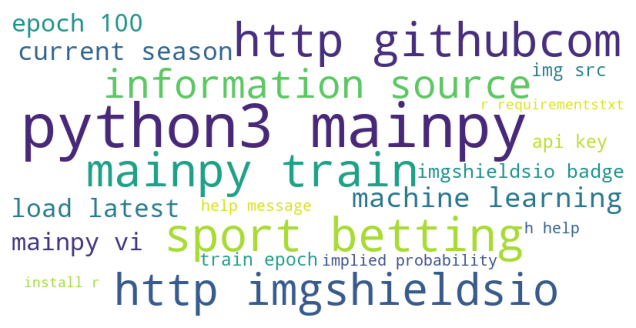

In [11]:
plot_bigrams(make_ngrams(python_words,2))

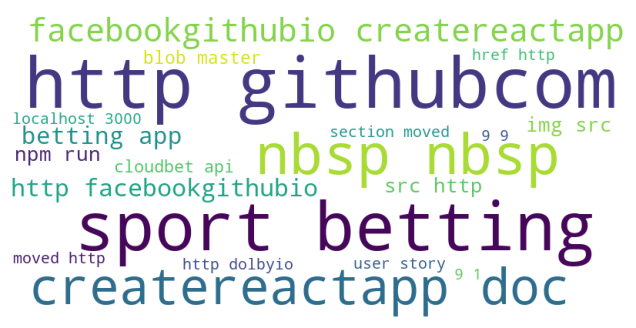

In [12]:
plot_bigrams(make_ngrams(java_script_words,2))

In [13]:
# setting basic style parameters for matplotlib
plt.rc('figure', figsize=(13, 7))
plt.style.use('seaborn-darkgrid')

In [14]:
# lets combine all 3 dfs horizontally
# fill any missing values with zero
# convert the resulting df to contain only integer values:

word_counts = pd.concat([python_freq, java_script_freq, jupyter_notebook_freq,
                        html_freq, r_freq, all_freq], axis=1).fillna(0).astype(int)

# rename the col names
word_counts.columns = ['python', 'java_script', 'jupyter_notebook', 'html', 'r', 'all']

word_counts.head()

,python,java_script,jupyter_notebook,html,r,all
odds,53,11,11,1,43,238
http,51,130,30,37,33,674
betting,31,45,13,4,7,215
bet,29,36,13,6,11,319
sport,28,43,19,2,8,233


<AxesSubplot:>

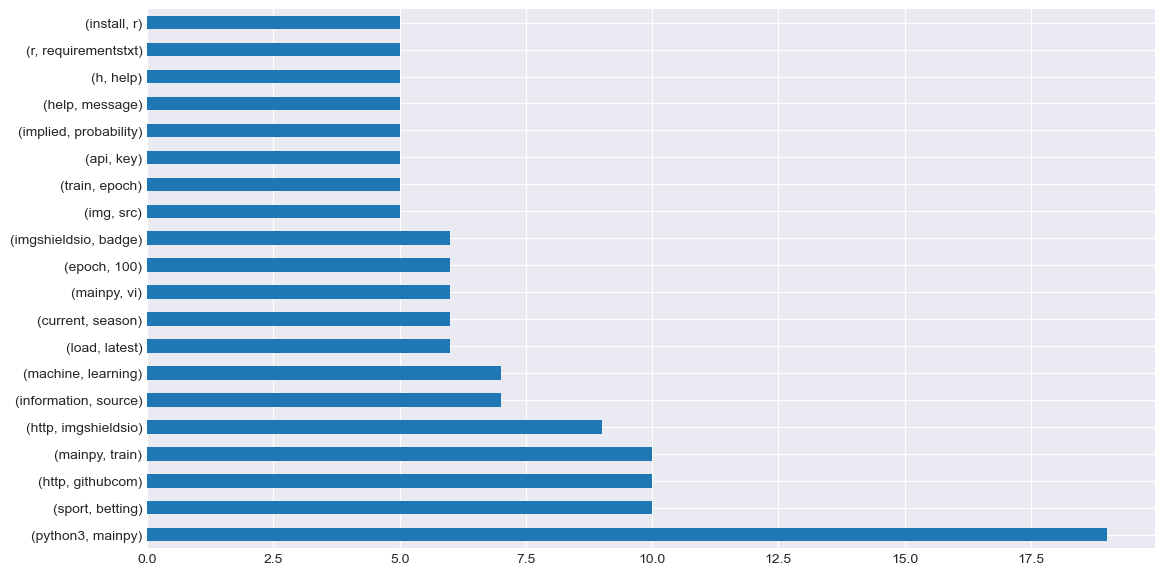

In [15]:
pd.Series(nltk.ngrams(python_words,2)).value_counts().head(20).plot.barh()


In [70]:
pd.Series(nltk.ngrams(java_script_words,2)).value_counts().head(20)

(http, githubcom)                     38
(sport, betting)                      35
(nbsp, nbsp)                          24
(createreactapp, doc)                 21
(facebookgithubio, createreactapp)    21
(http, facebookgithubio)              21
(betting, app)                        20
(npm, run)                            14
(src, http)                           14
(img, src)                            14
(blob, master)                        11
(cloudbet, api)                       10
(9, 9)                                 8
(http, dolbyio)                        8
(9, 1)                                 8
(section, moved)                       8
(href, http)                           8
(moved, http)                          8
(localhost, 3000)                      8
(user, story)                          8
dtype: int64

In [43]:
# df.original = df.original.str.replace('[/,_,-,:,"]', ' ', regex=True)

In [44]:
# pd.set_option("display.max_colwidth", None)

In [45]:
# pd.reset_option("display.max_colwidth")

In [46]:
# df.language.value_counts()

## Explore Questions!

1. What are the most common words in Python/JavaScript sports betting repos?


In [16]:
word_counts[['python']].sort_values(by='python', ascending=False).head()

,python
odds,53
http,51
betting,31
bet,29
sport,28


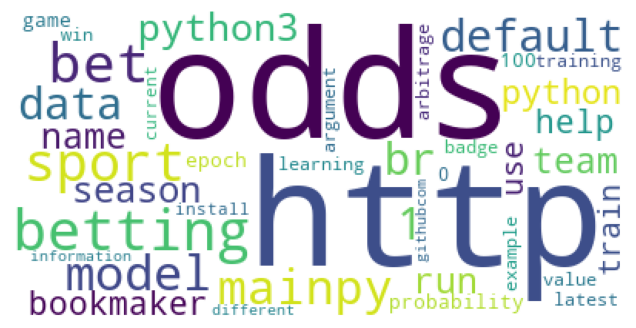

In [17]:
blog_img = WordCloud(background_color='white').generate_from_frequencies(python_freq.head(40))
plt.figure(figsize=(8, 4))
plt.imshow(blog_img)
plt.axis('off')
plt.show()

In [87]:
word_counts[['java_script']].sort_values(by='java_script', ascending=False).head()

,java_script
http,130
app,64
user,45
betting,45
sport,43


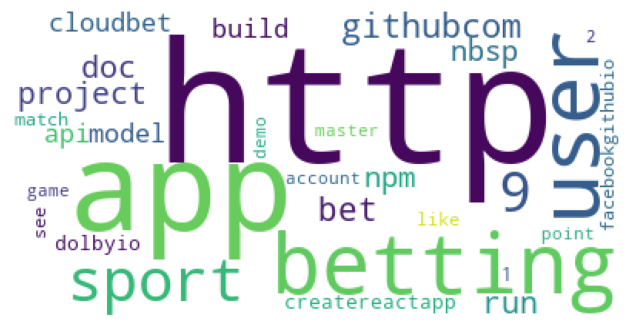

In [148]:
blog_img = WordCloud(background_color='white').generate_from_frequencies(java_script_freq.head(30))
plt.figure(figsize=(8, 4))
plt.imshow(blog_img)
plt.axis('off')
plt.show()

2. Five most common words?


In [85]:
word_counts.sort_values(by='all', ascending=False).head()

,python,java_script,jupyter_notebook,html,r,all
http,51,130,30,37,33,674
bet,29,36,13,6,11,319
odds,53,11,11,1,43,238
sport,28,43,19,2,8,233
betting,31,45,13,4,7,215


In [83]:
word_counts[['all']].sort_values(by='all', ascending=False).head()

,all
http,674
bet,319
odds,238
sport,233
betting,215


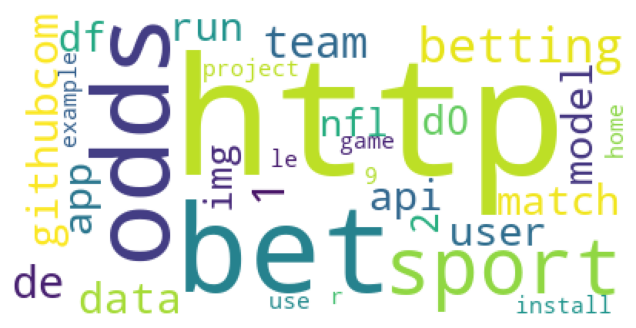

In [149]:
blog_img = WordCloud(background_color='white').generate_from_frequencies(all_freq.head(30))
plt.figure(figsize=(8, 4))
plt.imshow(blog_img)
plt.axis('off')
plt.show()

3. Does number of unique words vary between Python and JavaScript when it comes to sports betting repos?


In [116]:
unique_python_words = list(set(python_words))

In [118]:
len(unique_python_words)

1219

In [134]:
word_counts[word_counts.python != 0].java_script.value_counts().head()

0    861
1    118
2     65
3     43
5     24
Name: java_script, dtype: int64

In [119]:
unique_java_script_words = list(set(java_script_words))

In [120]:
len(unique_java_script_words)

1060

In [133]:
word_counts[word_counts.java_script != 0].python.value_counts().head()

0    702
1    140
2     65
3     39
6     22
Name: python, dtype: int64

4. Are there any words that uniquely identify a language used in sports betting repos?

In [122]:
#compare the words in python_words and java_script_words and return unique words from each
python_unique = [word for word in unique_python_words if word not in unique_java_script_words]
java_script_unique = [word for word in unique_java_script_words if word not in unique_python_words]

In [124]:
len(python_unique)

861

In [125]:
len(java_script_unique)

702

In [49]:
train[train.clean_norm_token.str.contains('bar')]

,repo,language,readme_contents,clean_norm_token
18,/rockscripts/Sport-Betting-APP-Betfair-Market,HTML,<h1>Sport Betting APP Betfair Market< h1>\n<p>...,h1sport betting app betfair market h1 pi autho...
0,/kyleskom/NBA-Machine-Learning-Sports-Betting,Python,# NBA Sports Betting Using Machine Learning 🏀\...,nba sport betting using machine learning img s...
8,/llSourcell/sports_betting_with_reinforcement_...,Python,# Sports Betting with RL\n\n\n## Overview\n\nT...,sport betting rl overview code http youtube me...
47,/pwu97/bettingtools,R,<!-- README.md is generated from README.Rmd. P...,readmemd generated readmermd please edit file ...


---

# Functions for Final Notebook!!!

In [4]:
def clean(df):
    '''
    This function will clean the df
    drop nulls, replace special characters
    '''
    # drop nulls
    df = df.dropna()
    # replace special characters with space
    df.readme_contents = df.readme_contents.str.replace('[/,_,-,:,"]', ' ', regex=True)
    # replace heavy, check, and mark with nothing
    df.readme_contents = df.readme_contents.str.replace('heavy', '').str.replace('check', '').str.replace('mark', '')
    # create column with clean text. Tokenized, normalized, lemmatized, stop words removed
    df['clean_norm_token'] = df.readme_contents.apply(w.tokenize).apply(w.basic_clean).apply(w.remove_stopwords).apply(w.lemmatize)
    # replace 124 with nothing. 124 was created by the program removing '|'
    df.clean_norm_token = df.clean_norm_token.str.replace('124', '')
    #in language column replace language with other if it is not in the top 5 languages
    top_5 = df.language.value_counts().head(5).index.tolist()
    df.language = df.language.apply(lambda x: x if x in top_5 else 'other')
    
    return df

In [5]:
# df = clean(df)

In [18]:
def python_wordcloud():
    '''
    this funtion will plot a wordcloud for top 40 python words
    '''
    blog_img = WordCloud(background_color='white').generate_from_frequencies(python_freq.head(40))
    plt.figure(figsize=(8, 4))
    plt.imshow(blog_img)
    plt.axis('off')
    plt.show()

In [20]:
# python_wordcloud()

In [63]:
def java_script_wordcloud():
    '''
    this function will plot a wordcloud for top 40 java script words
    '''
    blog_img = WordCloud(background_color='white').generate_from_frequencies(java_script_freq.head(40))
    plt.figure(figsize=(8, 4))
    plt.imshow(blog_img)
    plt.axis('off')
    plt.show()

In [62]:
# java_script_wordcloud()

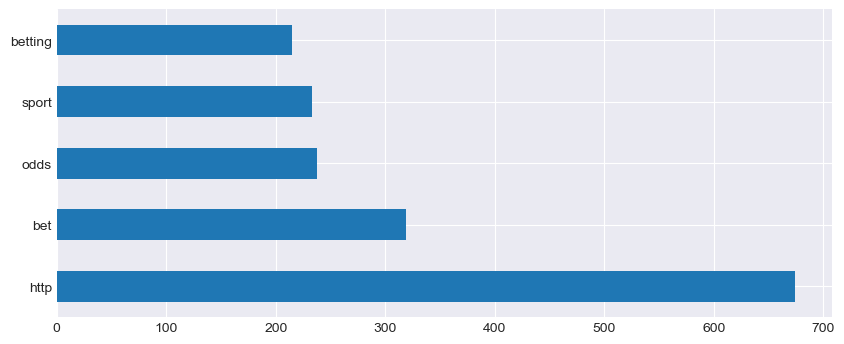

In [67]:

plt.figure(figsize=(10,4))
pd.Series(all_words).value_counts().head().plot.barh()
plt.show()

In [64]:
def unique_words_for_language():
    '''
    This fucntion will find the number of unique words in python and java script repos
    '''
    
    unique_python_words = list(set(python_words))
    unique_java_script_words = list(set(java_script_words))
    #compare the words in python_words and java_script_words and return unique words from each
    python_unique = [word for word in unique_python_words if word not in unique_java_script_words]
    java_script_unique = [word for word in unique_java_script_words if word not in unique_python_words]
    
    print(f'     Number of unique Python words: {len(python_unique)}')
    print(f'Number of unique Java Script words: {len(java_script_unique)}')

In [65]:
unique_words_for_language()

     Number of unique Python words: 861
Number of unique Java Script words: 702


---

## Modeling Phase!

In [42]:
#sets the X and y variables for train, validate, and test
X_train = train.clean_norm_token
y_train = train.language
X_validate = validate.clean_norm_token
y_validate = validate.language
X_test = test.clean_norm_token
y_test = test.language

In [43]:
X_train.head()

96    gamblor web application assist user finding hi...
18    h1sport betting app betfair market h1 pi autho...
78    livestream viewer image img livestreamdemopng ...
28    nitrogensportsanalysis script meant filtering ...
16    title readme output md document variant github...
Name: clean_norm_token, dtype: object

In [78]:
#make my bag of words Term Frequency 
cv = CountVectorizer()
X_bow = cv.fit_transform(X_train) 
X_validate_bow = cv.transform(X_validate)
X_test_bow = cv.transform(X_test)

In [72]:
X_validate_bow.shape

(20, 16990)

In [47]:
#auto runs through knn models with k values 5-20
atm.auto_knn_scores(X_bow, y_train, X_validate_bow, y_validate)

     k  train_accuracy  validate_accuracy     delta
0    5        0.600000               0.15  0.450000
2    7        0.433333               0.20  0.233333
1    6        0.416667               0.20  0.216667
3    8        0.466667               0.25  0.216667
13  18        0.416667               0.25  0.166667
4    9        0.383333               0.25  0.133333
14  19        0.416667               0.30  0.116667
5   10        0.316667               0.20  0.116667
11  16        0.400000               0.30  0.100000
7   12        0.300000               0.20  0.100000
12  17        0.333333               0.25  0.083333
6   11        0.316667               0.25  0.066667
8   13        0.266667               0.20  0.066667
9   14        0.350000               0.30  0.050000
10  15        0.383333               0.40 -0.016667


In [48]:
def k_nearest2(X_train_scaled, y_train, X_validate_scaled, y_validate):
    """
    Trains and evaluates KNN models for different values of k and plots the results.
    Parameters:
    -----------
    X_train: array-like, shape (n_samples, n_features)
        Training input samples.
    y_train: array-like, shape (n_samples,)
        Target values for the training input samples.
    X_validate: array-like, shape (n_samples, n_features)
        Validation input samples.
    y_validate: array-like, shape (n_samples,)
        Target values for the validation input samples.
    Returns:
    --------
    results: pandas DataFrame
        Contains the train and validation accuracy for each value of k.
    """
    metrics = []
    train_score = []
    validate_score = []
    for k in range(1,21):
        knn = KNeighborsClassifier(n_neighbors=k)
        knn.fit(X_train_scaled, y_train)
        train_score.append(knn.score(X_train_scaled, y_train))
        validate_score.append(knn.score(X_validate_scaled, y_validate))
        diff_score = train_score[-1] - validate_score[-1]
        metrics.append({'k': k, 'train_score': train_score[-1], 'validate_score': validate_score[-1], 'diff_score': diff_score})
    baseline_accuracy = y_train.value_counts().max() / y_train.value_counts().sum()
    results = pd.DataFrame.from_records(metrics)
    # modify the last few lines of the function
    # drop the diff_score column before plotting
    results_for_plotting = results.drop(columns=['diff_score'])
    with sns.axes_style('whitegrid'):
        ax = results_for_plotting.set_index('k').plot(figsize=(16,9))
    plt.ylabel('Accuracy')
    plt.axhline(baseline_accuracy, linewidth=2, color='black', label='baseline')
    plt.xticks(np.arange(0,21,1))
    min_diff_idx = np.abs(results['diff_score']).argmin()
    min_diff_k = results.loc[min_diff_idx, 'k']
    min_diff_score = results.loc[min_diff_idx, 'diff_score']
    ax.axvline(min_diff_k, linestyle='--', linewidth=2, color='red', label=f'min diff at k={min_diff_k} (diff={min_diff_score:.3f})')
    plt.fill_between(results['k'], train_score, validate_score, alpha=0.2, color='gray', where=(results['k'] > 0))
    plt.title('K Nearest Neighbor', fontsize=18)
    plt.legend()
    plt.show()
    
    return results


In [49]:
y_train.value_counts().max() / y_train.value_counts().sum()

0.26666666666666666

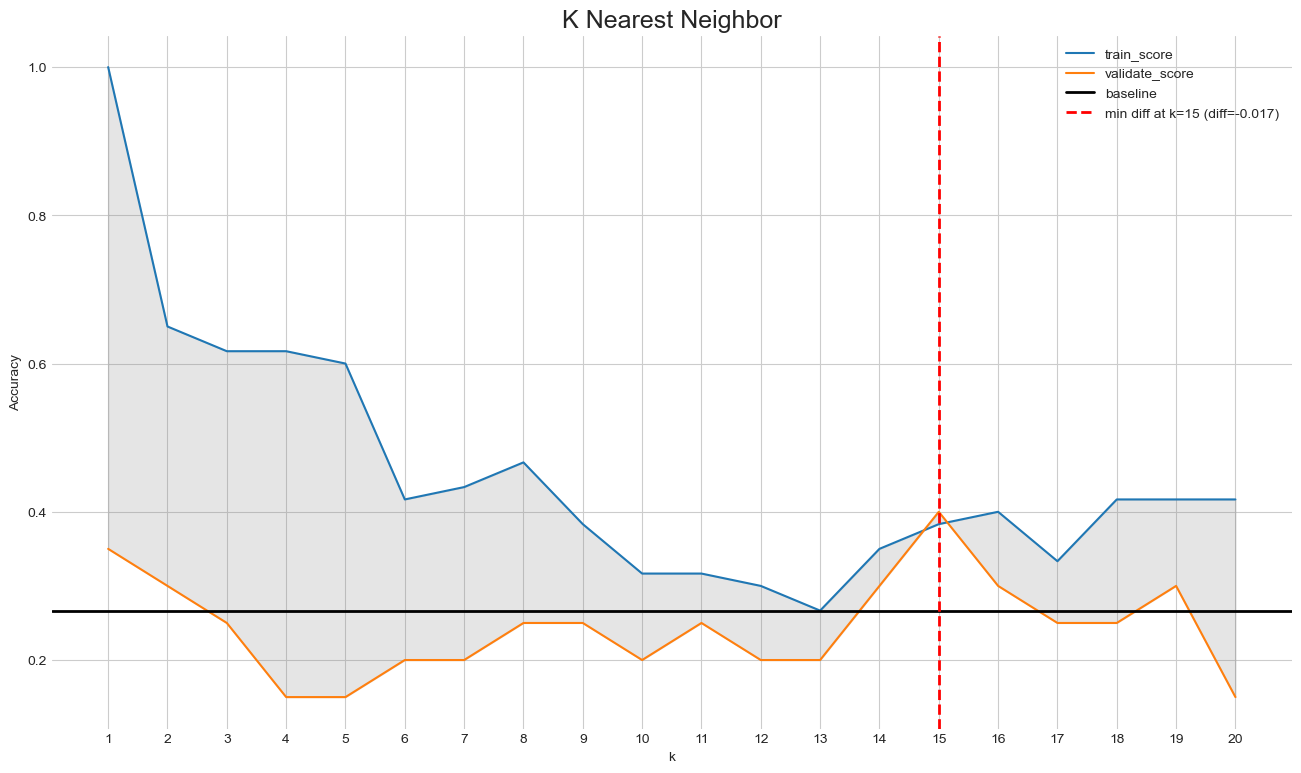

,k,train_score,validate_score,diff_score
0,1,1.000000,0.35,0.650000
1,2,0.650000,0.30,0.350000
2,3,0.616667,0.25,0.366667
3,4,0.616667,0.15,0.466667
4,5,0.600000,0.15,0.450000
5,6,0.416667,0.20,0.216667
6,7,0.433333,0.20,0.233333
7,8,0.466667,0.25,0.216667
8,9,0.383333,0.25,0.133333
9,10,0.316667,0.20,0.116667


In [79]:
k_nearest2(X_bow, y_train, X_validate_bow, y_validate)

In [51]:
#auto runs through random forest models with max_depth values 5-20
atm.auto_random_forest_scores(X_bow, y_train, X_validate_bow, y_validate)

    max_depth  train_accuracy  validate_accuracy     delta
5          10        1.000000               0.30  0.700000
8          13        1.000000               0.30  0.700000
10         15        1.000000               0.30  0.700000
12         17        1.000000               0.30  0.700000
13         18        1.000000               0.30  0.700000
14         19        1.000000               0.30  0.700000
2           7        0.966667               0.30  0.666667
4           9        1.000000               0.35  0.650000
6          11        1.000000               0.35  0.650000
7          12        1.000000               0.35  0.650000
9          14        1.000000               0.35  0.650000
11         16        1.000000               0.35  0.650000
0           5        0.916667               0.30  0.616667
3           8        1.000000               0.40  0.600000
15         20        1.000000               0.40  0.600000
1           6        0.933333               0.35  0.5833

In [52]:
def random_forest_scores(X_train_scaled, y_train, X_validate_scaled, y_validate):
    """
    Trains and evaluates a random forest classifier with different combinations of hyperparameters. The function takes in
    training and validation datasets, and returns a dataframe summarizing the model performance on each combination of
    hyperparameters.
    Parameters:
    -----------
    X_train : pandas DataFrame
        Features of the training dataset.
    y_train : pandas Series
        Target variable of the training dataset.
    X_validate : pandas DataFrame
        Features of the validation dataset.
    y_validate : pandas Series
        Target variable of the validation dataset.
    Returns:
    --------
    df : pandas DataFrame
        A dataframe summarizing the model performance on each combination of hyperparameters.
    """
    #define variables
    train_scores = []
    validate_scores = []
    min_samples_leaf_values = [1, 2, 3, 4, 5, 6, 7, 8 , 9, 10]
    max_depth_values = [10, 9, 8, 7, 6, 5, 4, 3, 2, 1]
    for min_samples_leaf, max_depth in zip(min_samples_leaf_values, max_depth_values):
        rf = RandomForestClassifier(min_samples_leaf=min_samples_leaf, max_depth=max_depth,random_state=123)
        rf.fit(X_train_scaled, y_train)
        train_score = rf.score(X_train_scaled, y_train)
        validate_score = rf.score(X_validate_scaled, y_validate)
        train_scores.append(train_score)
        validate_scores.append(validate_score)
    # Calculate the difference between the train and validation scores
    diff_scores = [train_score - validate_score for train_score, validate_score in zip(train_scores, validate_scores)]
    #Put results into a dataframe
    df = pd.DataFrame({
        'min_samples_leaf': min_samples_leaf_values,
        'max_depth': max_depth_values,
        'train_score': train_scores,
        'validate_score': validate_scores,
        'diff_score': diff_scores})
    # Set plot style
    sns.set_style('whitegrid')
    # Create plot
    plt.figure(figsize=(8, 6))
    plt.plot(max_depth_values, train_scores, label='train', marker='o', color='blue')
    plt.plot(max_depth_values, validate_scores, label='validation', marker='o', color='orange')
    plt.fill_between(max_depth_values, train_scores, validate_scores, alpha=0.2, color='gray')
    plt.xticks([2,4,6,8,10],['Leaf 9 and Depth 2','Leaf 7 and Depth 4','Leaf 5 and Depth 6','Leaf 3 and Depth 8','Leaf 1and Depth 10'], rotation = 45)
    plt.xlabel('min_samples_leaf and max_depth', fontsize=14)
    plt.ylabel('Accuracy', fontsize=14)
    plt.title('Random Forest Classifier Performance', fontsize=18)
    plt.legend(fontsize=12)
    plt.show()
    
    return df


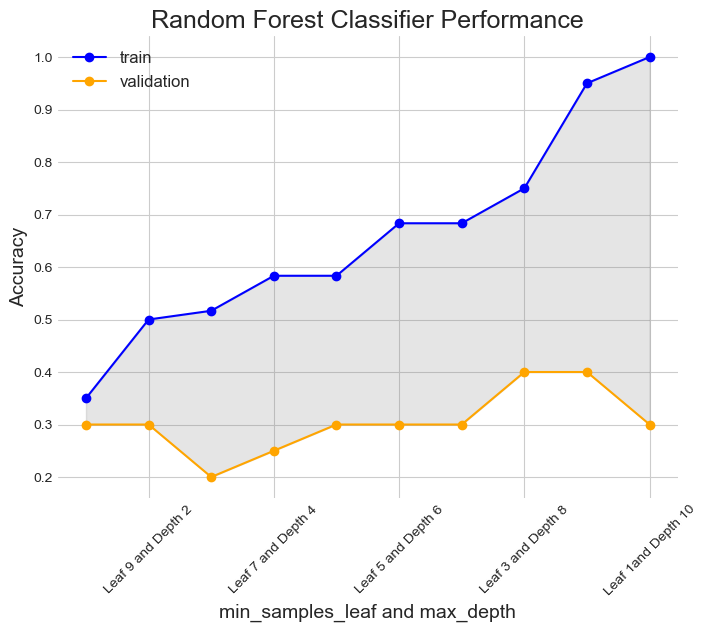

,min_samples_leaf,max_depth,train_score,validate_score,diff_score
0,1,10,1.000000,0.30,0.700000
1,2,9,0.950000,0.40,0.550000
2,3,8,0.750000,0.40,0.350000
3,4,7,0.683333,0.30,0.383333
4,5,6,0.683333,0.30,0.383333
5,6,5,0.583333,0.30,0.283333
6,7,4,0.583333,0.25,0.333333
7,8,3,0.516667,0.20,0.316667
8,9,2,0.500000,0.30,0.200000
9,10,1,0.350000,0.30,0.050000


In [53]:
random_forest_scores(X_bow, y_train, X_validate_bow, y_validate)

In [54]:
#auto runs through decision tree models with the "entropy" parameter with max_depth values 5-20
atm.auto_random_forest_entropy_scores(X_bow, y_train, X_validate_bow, y_validate)

    max_depth  train_accuracy  validate_accuracy     delta
7          12        1.000000               0.20  0.800000
9          14        1.000000               0.20  0.800000
10         15        1.000000               0.20  0.800000
12         17        1.000000               0.20  0.800000
13         18        1.000000               0.20  0.800000
14         19        1.000000               0.20  0.800000
15         20        1.000000               0.20  0.800000
8          13        1.000000               0.25  0.750000
11         16        1.000000               0.25  0.750000
5          10        1.000000               0.30  0.700000
3           8        1.000000               0.35  0.650000
4           9        1.000000               0.35  0.650000
6          11        1.000000               0.35  0.650000
0           5        0.950000               0.30  0.650000
1           6        0.983333               0.35  0.633333
2           7        1.000000               0.40  0.6000

In [55]:
#auto runs through logistic regression models with C values .1-1
atm.auto_lo_regress_scores(X_bow, y_train, X_validate_bow, y_validate)

   c_range  train_accuracy  validate_accuracy  delta
0      0.1             1.0               0.30   0.70
6      0.7             1.0               0.30   0.70
7      0.8             1.0               0.30   0.70
8      0.9             1.0               0.30   0.70
3      0.4             1.0               0.35   0.65
4      0.5             1.0               0.35   0.65
5      0.6             1.0               0.35   0.65
1      0.2             1.0               0.40   0.60
2      0.3             1.0               0.40   0.60


In [56]:
#make my bag of words TF-IDF
tfidf = TfidfVectorizer()
X_bow = tfidf.fit_transform(X_train) 
X_validate_bow = tfidf.transform(X_validate)
X_test_bow = tfidf.transform(X_test)

In [57]:
#auto runs through knn models with k values 5-20
atm.auto_knn_scores(X_bow, y_train, X_validate_bow, y_validate)

     k  train_accuracy  validate_accuracy     delta
2    7        0.566667               0.40  0.166667
3    8        0.600000               0.45  0.150000
0    5        0.566667               0.45  0.116667
7   12        0.483333               0.40  0.083333
9   14        0.483333               0.40  0.083333
4    9        0.516667               0.45  0.066667
8   13        0.466667               0.40  0.066667
1    6        0.500000               0.45  0.050000
5   10        0.500000               0.45  0.050000
6   11        0.500000               0.45  0.050000
10  15        0.533333               0.50  0.033333
13  18        0.483333               0.50 -0.016667
11  16        0.466667               0.50 -0.033333
12  17        0.466667               0.50 -0.033333
14  19        0.500000               0.55 -0.050000


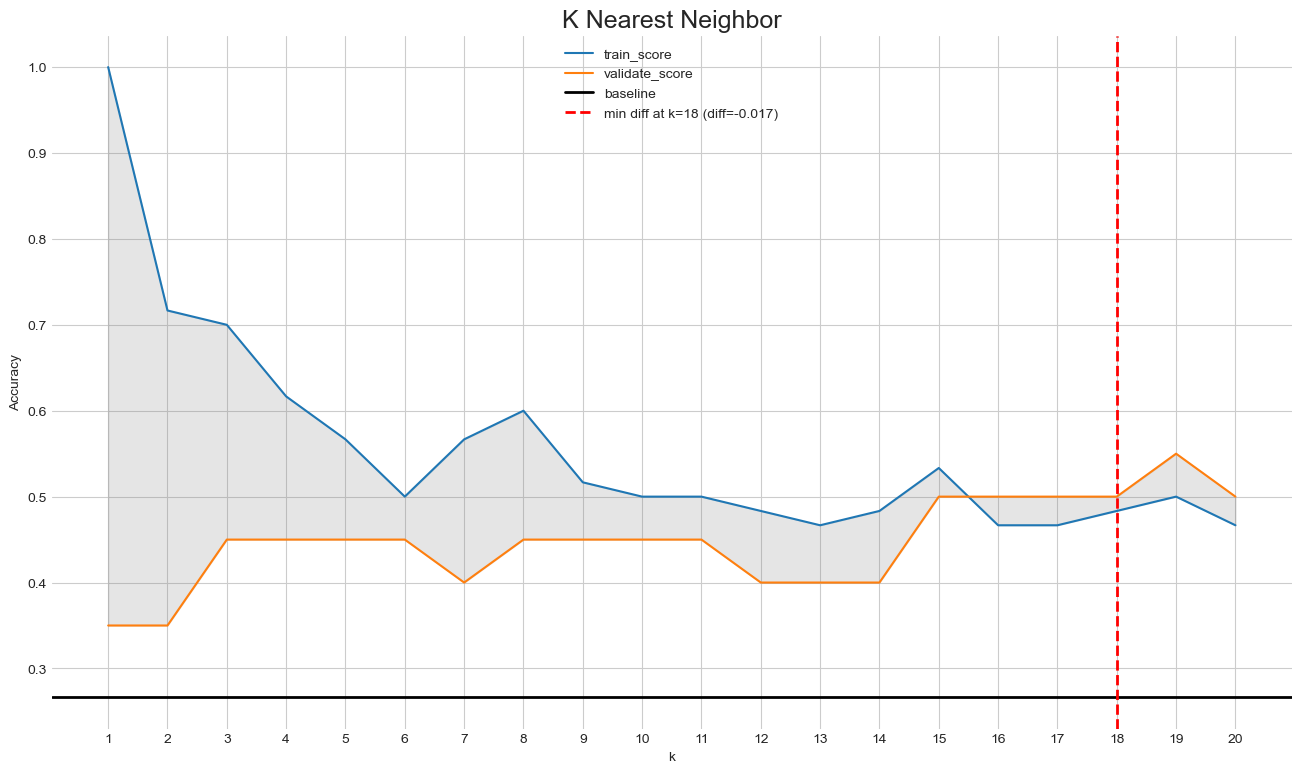

,k,train_score,validate_score,diff_score
0,1,1.000000,0.35,0.650000
1,2,0.716667,0.35,0.366667
2,3,0.700000,0.45,0.250000
3,4,0.616667,0.45,0.166667
4,5,0.566667,0.45,0.116667
5,6,0.500000,0.45,0.050000
6,7,0.566667,0.40,0.166667
7,8,0.600000,0.45,0.150000
8,9,0.516667,0.45,0.066667
9,10,0.500000,0.45,0.050000


In [58]:
k_nearest2(X_bow, y_train, X_validate_bow, y_validate)

In [59]:
#auto runs through random forest models with max_depth values 5-20
atm.auto_random_forest_scores(X_bow, y_train, X_validate_bow, y_validate)

    max_depth  train_accuracy  validate_accuracy     delta
2           7        0.983333               0.30  0.683333
6          11        1.000000               0.35  0.650000
1           6        0.983333               0.35  0.633333
3           8        1.000000               0.40  0.600000
4           9        1.000000               0.40  0.600000
5          10        1.000000               0.40  0.600000
8          13        1.000000               0.40  0.600000
0           5        0.933333               0.35  0.583333
7          12        1.000000               0.45  0.550000
9          14        1.000000               0.45  0.550000
10         15        1.000000               0.45  0.550000
15         20        1.000000               0.45  0.550000
11         16        1.000000               0.50  0.500000
12         17        1.000000               0.50  0.500000
13         18        1.000000               0.50  0.500000
14         19        1.000000               0.55  0.4500

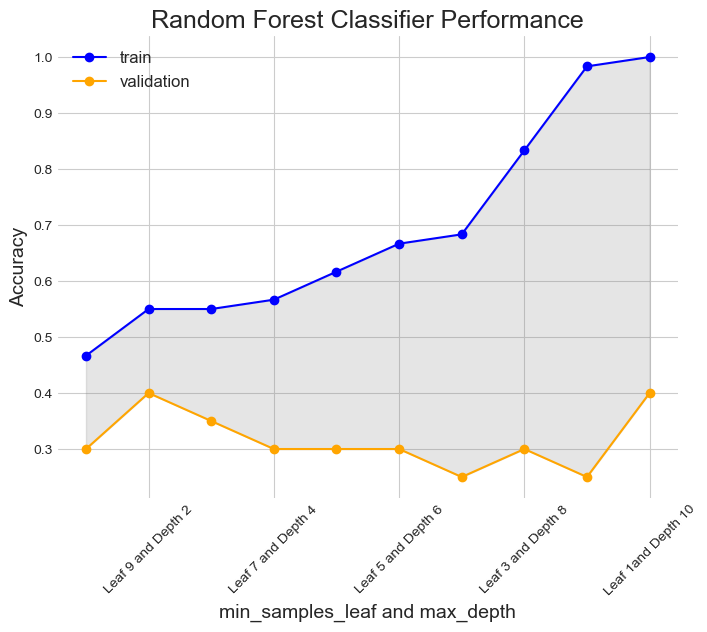

,min_samples_leaf,max_depth,train_score,validate_score,diff_score
0,1,10,1.000000,0.40,0.600000
1,2,9,0.983333,0.25,0.733333
2,3,8,0.833333,0.30,0.533333
3,4,7,0.683333,0.25,0.433333
4,5,6,0.666667,0.30,0.366667
5,6,5,0.616667,0.30,0.316667
6,7,4,0.566667,0.30,0.266667
7,8,3,0.550000,0.35,0.200000
8,9,2,0.550000,0.40,0.150000
9,10,1,0.466667,0.30,0.166667


In [60]:
random_forest_scores(X_bow, y_train, X_validate_bow, y_validate)

In [61]:
#auto runs through decision tree models with the "entropy" parameter with max_depth values 5-20
atm.auto_random_forest_entropy_scores(X_bow, y_train, X_validate_bow, y_validate)

    max_depth  train_accuracy  validate_accuracy     delta
1           6        1.000000               0.35  0.650000
2           7        1.000000               0.35  0.650000
5          10        1.000000               0.35  0.650000
9          14        1.000000               0.35  0.650000
0           5        0.983333               0.35  0.633333
3           8        1.000000               0.40  0.600000
4           9        1.000000               0.40  0.600000
6          11        1.000000               0.40  0.600000
7          12        1.000000               0.40  0.600000
8          13        1.000000               0.40  0.600000
15         20        1.000000               0.40  0.600000
10         15        1.000000               0.45  0.550000
13         18        1.000000               0.45  0.550000
14         19        1.000000               0.45  0.550000
11         16        1.000000               0.50  0.500000
12         17        1.000000               0.50  0.5000

In [62]:
#auto runs through logistic regression models with C values .1-1
atm.auto_lo_regress_scores(X_bow, y_train, X_validate_bow, y_validate)

   c_range  train_accuracy  validate_accuracy     delta
8      0.9        0.750000               0.35  0.400000
1      0.2        0.700000               0.30  0.400000
2      0.3        0.733333               0.35  0.383333
5      0.6        0.733333               0.35  0.383333
6      0.7        0.733333               0.35  0.383333
7      0.8        0.733333               0.35  0.383333
3      0.4        0.733333               0.40  0.333333
4      0.5        0.733333               0.40  0.333333
0      0.1        0.400000               0.30  0.100000
